In [1]:
from pycocotools.coco import COCO
from transformers import AutoImageProcessor, DefaultDataCollator, create_optimizer, TFAutoModelForImageClassification
from datasets import load_dataset, Dataset, ClassLabel
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers.keras_callbacks import KerasMetricCallback
import numpy as np
import tensorflow as tf
import PIL as Image


In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [8]:
coco = COCO(annotation_file="/Users/stashakkarainen/Desktop/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=20.27s)
creating index...
index created!


In [9]:
cat_cat = coco.getCatIds(catNms="cat")
horse_cat = coco.getCatIds(catNms="horse")
train_cat = coco.getCatIds(catNms="train")
zebra_cat = coco.getCatIds(catNms="zebra")

In [10]:
cat_imgs = coco.getImgIds(catIds=cat_cat)
horse_imgs = coco.getImgIds(catIds=horse_cat)
train_imgs = coco.getImgIds(catIds=train_cat)
zebra_imgs = coco.getImgIds(catIds=zebra_cat)

In [11]:
import random

In [12]:
random.shuffle(cat_imgs)
cat_imgs_train = cat_imgs[:400]
cat_imgs_test = cat_imgs[400:600]

random.shuffle(horse_imgs)
horse_imgs_train = horse_imgs[:400]
horse_imgs_test = horse_imgs[400:600]

random.shuffle(train_imgs)
train_imgs_train = train_imgs[:400]
train_imgs_test = train_imgs[400:600]

random.shuffle(zebra_imgs)
zebra_imgs_train = zebra_imgs[:400]
zebra_imgs_test = zebra_imgs[400:600]

In [13]:
cat_meta_train = coco.loadImgs(ids=cat_imgs_train)
cat_meta_test = coco.loadImgs(ids=cat_imgs_test)

horse_meta_train = coco.loadImgs(ids=horse_imgs_train)
horse_meta_test = coco.loadImgs(ids=horse_imgs_test)

train_meta_train = coco.loadImgs(ids=train_imgs_train)
train_meta_test = coco.loadImgs(ids=train_imgs_test)

zebra_meta_train = coco.loadImgs(ids=zebra_imgs_train)
zebra_meta_test = coco.loadImgs(ids=zebra_imgs_test)

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [15]:
img = mpimg.imread("/Users/stashakkarainen/Desktop/train2017/{}".format(zebra_meta_train[0]['file_name']))

In [16]:
from PIL import Image

In [17]:
img = Image.open("/Users/stashakkarainen/Desktop/train2017/{}".format(zebra_meta_train[0]['file_name']))

In [18]:
def get_data(meta, datadir="/Users/stashakkarainen/Desktop/train2017"):
    return [(x['file_name'], Image.open("{}/{}".format(datadir, x['file_name'])).resize((224,224))) for x in meta]

In [19]:
cat_data_train = get_data(cat_meta_train)
horse_data_train = get_data(horse_meta_train)
cat_data_test = get_data(cat_meta_test)
horse_data_test = get_data(horse_meta_test)

train_data_train = get_data(train_meta_train)
train_data_test = get_data(train_meta_test)

zebra_data_train = get_data(zebra_meta_train)
zebra_data_test = get_data(zebra_meta_test)

In [20]:
import pandas as pd

In [21]:
cat_labels_train = [0]*len(cat_data_train)
cat_labels_test = [0]* len(cat_data_test)

In [22]:
horse_labels_train = [1]*len(horse_data_train)
horse_labels_test = [1]*len(horse_data_test)

In [23]:
train_labels_train = [2]*len(train_data_train)
train_labels_test = [2]*len(train_data_test)

In [24]:
zebra_labels_train = [3]*len(zebra_data_train)
zebra_labels_test = [3]*len(zebra_data_test)

In [25]:
pre_train_data = cat_data_train + horse_data_train + train_data_train + zebra_data_train
pre_train_labels = cat_labels_train + horse_labels_train + train_labels_train + zebra_labels_train
pre_test_data = cat_data_test + horse_data_test + train_data_test + zebra_data_test
pre_test_labels = cat_labels_test + horse_labels_test + train_labels_test + zebra_labels_test

In [26]:
pre_train_data[1]

('000000402448.jpg', <PIL.Image.Image image mode=RGB size=224x224>)

In [27]:
train_data = [{"image": image_data[1], "label":label} for image_data, label in zip(pre_train_data, pre_train_labels)]
test_data = [{"image": image_data[1], "label":label} for image_data, label in zip(pre_test_data, pre_test_labels)]

In [28]:
test_data = Dataset.from_dict({"image": [item["image"] for item in test_data], "label": [item["label"] for item in test_data]})
train_data = Dataset.from_dict({"image": [item["image"] for item in train_data], "label": [item["label"] for item in train_data]})

In [29]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [30]:
size = (image_processor.size["height"], image_processor.size["width"])

train_data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0/127.5, offset = -1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name = "train_data_augmentation"
)

val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale = 1.0/127.5, offset = -1),
    ],
    name = "val_data_augmentation"
)

In [31]:
def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    
    return tf.expand_dims(tf_image, 0)

def preprocess_train(example_batch):
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    pixel_values = [tf.transpose(tf.squeeze(image)).numpy() for image in images]
    
    example_batch["pixel_values"] = pixel_values
    
    return example_batch

def preprocess_val(example_batch):
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    pixel_values = [tf.transpose(tf.squeeze(image)).numpy() for image in images]
    
    example_batch["pixel_values"] = pixel_values
    
    return example_batch

In [32]:
train_data = train_data.map(preprocess_train, batched=True)
test_data = test_data.map(preprocess_train, batched=True)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [33]:
train_data.set_transform(preprocess_train)
test_data.set_transform(preprocess_val)

In [34]:
train_data[1400]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label': 3,
 'pixel_values': array([[[-0.8520703 , -0.84681076, -0.869409  , ..., -0.3907639 ,
          -0.4963658 , -0.49739212],
         [-0.8492969 , -0.84186864, -0.8732277 , ..., -0.3498603 ,
          -0.49605024, -0.46784753],
         [-0.85692006, -0.85128206, -0.87978274, ..., -0.35957992,
          -0.4845246 , -0.4411782 ],
         ...,
         [-0.786737  , -0.6659197 , -0.6276805 , ..., -0.4965855 ,
          -0.48199293, -0.44523415],
         [-0.79105484, -0.6621527 , -0.6315523 , ..., -0.47601068,
          -0.4541387 , -0.41574433],
         [-0.79700136, -0.6638857 , -0.62872016, ..., -0.46801355,
          -0.4122619 , -0.2198481 ]],
 
        [[-0.8282672 , -0.81807846, -0.8369988 , ..., -0.39741313,
          -0.48831972, -0.48807707],
         [-0.8312109 , -0.8191388 , -0.84503   , ..., -0.35930204,
          -0.4856483 , -0.46814483],
         [-0.8285102 , -0.8230071 , -0.8487871 , 

In [35]:
data_collator = DefaultDataCollator(return_tensors="tf")

In [36]:
import evaluate

accuracy = evaluate.load("accuracy")

In [37]:
def compute_metrics(eval_pred):
    predictions,label = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    
    return accuracy.compute(predictions = predictions, references = label)

In [38]:
batch_size = 16
num_epochs = 5
num_train_steps = len(train_data)*num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr = learning_rate,
    num_train_steps = num_train_steps,
    weight_decay_rate = weight_decay_rate,
    num_warmup_steps = 0,
)

In [39]:
model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels  = 4
    
)



tf_train_dataset = train_data.to_tf_dataset(
    columns ="pixel_values", label_cols = "label", shuffle=True, batch_size = batch_size, collate_fn = data_collator
)

tf_eval_dataset = test_data.to_tf_dataset(
    columns = "pixel_values", label_cols = "label", shuffle=True, batch_size = batch_size, collate_fn = data_collator
)

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = optimizer, loss=loss)

In [41]:
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

metric_callback = KerasMetricCallback(metric_fn = compute_metrics, eval_dataset=tf_eval_dataset)
push_to_hub_callback = PushToHubCallback(
    output_dir="assignment_part_3",
    tokenizer=image_processor,
    save_strategy="no",
)
callbacks = [metric_callback, push_to_hub_callback]

/Users/stashakkarainen/Desktop/assignment/assignment_part_3 is already a clone of https://huggingface.co/aspends/assignment_part_3. Make sure you pull the latest changes with `repo.git_pull()`.


In [42]:


model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs = num_epochs, callbacks = callbacks)

Epoch 1/5
100/100 [==============================] - 1020s 10s/step - loss: 0.8768 - val_loss: 0.4404 - accuracy: 0.9387
Epoch 2/5
100/100 [==============================] - 1004s 10s/step - loss: 0.3198 - val_loss: 0.2664 - accuracy: 0.9475
Epoch 3/5
100/100 [==============================] - 990s 10s/step - loss: 0.1919 - val_loss: 0.2303 - accuracy: 0.9425
Epoch 4/5
100/100 [==============================] - 1024s 10s/step - loss: 0.1357 - val_loss: 0.1959 - accuracy: 0.9463
Epoch 5/5
100/100 [==============================] - 1201s 12s/step - loss: 0.0932 - val_loss: 0.2218 - accuracy: 0.9313


Upload file tf_model.h5:   0%|          | 1.00/328M [00:00<?, ?B/s]

To https://huggingface.co/aspends/assignment_part_3
   3ed80ef..989f064  main -> main



In [51]:
image = test_data[799]["image"]

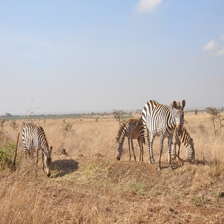

In [52]:
image

In [60]:
from transformers import pipeline

classifier = pipeline(
    "image-classification",
    model="aspends/assignment_part_3",
    device=0,
    framework="tf"
)

classifier(image)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at aspends/assignment_part_3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


[{'score': 0.942626416683197, 'label': 'zebra'},
 {'score': 0.02158680185675621, 'label': 'train'},
 {'score': 0.018928898498415947, 'label': 'cat'},
 {'score': 0.016857799142599106, 'label': 'horse'}]